In [1]:
# Import libraries
!pip install shap
!pip install pandas-gbq
import shap
shap.initjs()
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from google.cloud import bigquery 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
import numpy as np
from sklearn.ensemble import IsolationForest 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [2]:
# Initialize connection 
project = !gcloud config get-value project
project_id = project[0]
bq = bigquery.Client(project = project_id)

In [3]:
# Read dataset in from Big Query
dataset = 'ltaylor'
table = 'Cost_02_Copy_2'
query = f"""
SELECT * 
FROM `{project_id}.{dataset}.{table}`
"""
df = bq.query(query = query).to_dataframe()
df.head()

,invoice_date,service_description,sku_description,project_id,business_unit,cost
0,2022-03-31,Cloud Scheduler,Jobs,clgx-surveillance-prd-f609,None,0.002290
1,2022-03-31,BigQuery,Analysis,clgx-surveillance-sbx-f577,None,14.392636
2,2022-03-31,BigQuery,Analysis,clgx-surveillance-dev-9e5e,None,8.326224
3,2022-03-31,BigQuery,Analysis,clgx-surveillance-prd-f609,None,0.003426
4,2022-03-31,Cloud Functions,CPU Time,clgx-surveillance-sbx-f577,None,0.000000


# EDA/Data Cleaning

In [4]:
# Null values
df.isna().sum()

invoice_date                0
service_description         0
sku_description             0
project_id                  0
business_unit          100576
cost                        0
dtype: int64

In [5]:
# Value counts by service
df['service_description'].value_counts()

service_description
Cloud Storage                              95476
BigQuery                                   70680
Compute Engine                             21853
Cloud Functions                            19133
Cloud Pub/Sub                              12016
Cloud Logging                              11277
Networking                                  1605
Google Click to Deploy Deep Learning VM     1488
Cloud Scheduler                             1062
Vertex AI                                    927
Notebooks                                    451
Artifact Registry                            293
Deep Learning VM                             246
BigQuery Storage API                         210
Cloud Dataflow                               193
Cloud Build                                  129
Stackdriver Logging                          108
Cloud Machine Learning Engine                 35
Cloud Monitoring                               6
Name: count, dtype: int64

In [6]:
# Number of distinct values in service description
len(df['service_description'].unique())

19

In [7]:
# Top 20 sku description value counts
df['sku_description'].value_counts()[0:20]

sku_description
Standard Storage US Multi-region                                     26195
Long Term Logical Storage                                            21223
Active Logical Storage                                               19008
Download Worldwide Destinations (excluding Asia & Australia)         12230
Long Term Storage                                                    11598
Active Storage                                                       10338
Multi-Region Standard Class A Operations                             10100
Log Volume                                                            8487
Standard Storage US Regional                                          7232
Nearline Storage US Multi-region                                      6766
Analysis                                                              6340
Coldline Storage US Multi-region                                      6062
Invocations                                                           5384
CPU Time 

In [8]:
# Number of distinct values in sku description
len(df['sku_description'].unique())

233

In [9]:
# Project id value counts
df['project_id'].value_counts()

project_id
clgx-surveillance-sbx-f577       69110
clgx-surveillance-dev-9e5e       64619
clgx-surveillance-prd-f609       42663
clgx-surveillance-prf-ad2a       15922
clgx-surveillance-dr-66e6         9741
clgx-surveillance-int-4316        9518
clgx-surveillance-reg-ec2c        6702
clgx-surveillance-sc-prd-3310     4282
clgx-surveillance-np-reg-ccfe     3860
clgx-surveillance-uat-bf45        3630
clgx-surveillance-sc-sbx-750d     2959
clgx-surveillance-sc-dev-28c2     1662
clgx-surveillance-poc-b10b        1329
clgx-surveillance-sc-uat-2408     1191
Name: count, dtype: int64

In [10]:
# Number of distinct values in project_id
len(df['project_id'].unique())

14

In [11]:
# Sum of cost by service description
group_df = df.groupby('service_description')['cost'].sum().sort_values(ascending = False)
group_df

service_description
Cloud Storage                              1.210352e+06
BigQuery                                   8.152292e+05
Compute Engine                             1.574421e+04
Cloud Functions                            4.754313e+03
Notebooks                                  7.890235e+02
Cloud Dataflow                             9.795310e+01
Cloud Machine Learning Engine              4.258576e+01
Vertex AI                                  3.627102e+01
BigQuery Storage API                       3.387602e+01
Networking                                 2.802867e+01
Cloud Pub/Sub                              2.977891e+00
Cloud Scheduler                            2.349704e+00
Artifact Registry                          4.364570e-01
Cloud Build                                2.856660e-01
Cloud Monitoring                           5.600000e-05
Deep Learning VM                           0.000000e+00
Google Click to Deploy Deep Learning VM    0.000000e+00
Cloud Logging               

In [12]:
# Average cost
np.mean(df['cost'])

8.630763379580756

# Feature Engineering

In [13]:
df = df.sort_values('invoice_date')

In [14]:
df['invoice_date'] = pd.to_datetime(df['invoice_date'],format='%m-%d-%Y')

In [15]:
# One-hot encode columns
enc_df = df.copy()
enc_df = pd.get_dummies(enc_df)
enc_df.head()

,invoice_date,cost,service_description_Artifact Registry,service_description_BigQuery,service_description_BigQuery Storage API,service_description_Cloud Build,service_description_Cloud Dataflow,service_description_Cloud Functions,service_description_Cloud Logging,service_description_Cloud Machine Learning Engine,...,business_unit_riskmodel,business_unit_rqe,business_unit_scheduled_query,business_unit_spatial,business_unit_tax,business_unit_template_example,business_unit_test,business_unit_thvx,business_unit_weather,business_unit_wildfire
99592,2021-07-05,0.0,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
99591,2021-07-05,0.0,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
99593,2021-07-05,0.0,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
99587,2021-07-05,0.0,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
99594,2021-07-05,0.0,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [16]:
# Make columns binary (1,0)
for i in enc_df.drop(columns = ['cost','invoice_date'], axis = 1).columns:
    enc_df[i] = np.where(enc_df[i] == True, 1,0)
enc_df.head()

,invoice_date,cost,service_description_Artifact Registry,service_description_BigQuery,service_description_BigQuery Storage API,service_description_Cloud Build,service_description_Cloud Dataflow,service_description_Cloud Functions,service_description_Cloud Logging,service_description_Cloud Machine Learning Engine,...,business_unit_riskmodel,business_unit_rqe,business_unit_scheduled_query,business_unit_spatial,business_unit_tax,business_unit_template_example,business_unit_test,business_unit_thvx,business_unit_weather,business_unit_wildfire
99592,2021-07-05,0.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
99591,2021-07-05,0.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
99593,2021-07-05,0.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
99587,2021-07-05,0.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
99594,2021-07-05,0.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [17]:
# Keep invoice_date, cost, along with Projects and sku's asscoiated with high costs
cols = ['invoice_date','cost', 'service_description_BigQuery','service_description_Cloud Storage','project_id_clgx-surveillance-sbx-f577','project_id_clgx-surveillance-dr-66e6','project_id_clgx-surveillance-int-4316',
                'sku_description_Coldline Storage US Multi-region','sku_description_Standard Storage US Multi-region', 'sku_description_Active Logical Storage','sku_description_Analysis',
                 'sku_description_Long Term Logical Storage', 'sku_description_Nearline Storage US Multi-region' , 'sku_description_Archive Storage US Multi-region']
enc_df = enc_df[cols]
enc_df.head()

,invoice_date,cost,service_description_BigQuery,service_description_Cloud Storage,project_id_clgx-surveillance-sbx-f577,project_id_clgx-surveillance-dr-66e6,project_id_clgx-surveillance-int-4316,sku_description_Coldline Storage US Multi-region,sku_description_Standard Storage US Multi-region,sku_description_Active Logical Storage,sku_description_Analysis,sku_description_Long Term Logical Storage,sku_description_Nearline Storage US Multi-region,sku_description_Archive Storage US Multi-region
99592,2021-07-05,0.0,0,0,1,0,0,0,0,0,0,0,0,0
99591,2021-07-05,0.0,0,0,1,0,0,0,0,0,0,0,0,0
99593,2021-07-05,0.0,0,0,1,0,0,0,0,0,0,0,0,0
99587,2021-07-05,0.0,0,0,1,0,0,0,0,0,0,0,0,0
99594,2021-07-05,0.0,0,0,1,0,0,0,0,0,0,0,0,0


In [18]:
# Shape of df 
enc_df.shape

(237188, 14)

In [19]:
# Create features from invoice_date
enc_df['invoice_date'] = pd.to_datetime(enc_df['invoice_date'],format='%m-%d-%Y')
#enc_df['invoice_day'] = enc_df['invoice_date'].dt.day
#enc_df['invoice_month'] = enc_df['invoice_date'].dt.month
enc_df.head()

,invoice_date,cost,service_description_BigQuery,service_description_Cloud Storage,project_id_clgx-surveillance-sbx-f577,project_id_clgx-surveillance-dr-66e6,project_id_clgx-surveillance-int-4316,sku_description_Coldline Storage US Multi-region,sku_description_Standard Storage US Multi-region,sku_description_Active Logical Storage,sku_description_Analysis,sku_description_Long Term Logical Storage,sku_description_Nearline Storage US Multi-region,sku_description_Archive Storage US Multi-region
99592,2021-07-05,0.0,0,0,1,0,0,0,0,0,0,0,0,0
99591,2021-07-05,0.0,0,0,1,0,0,0,0,0,0,0,0,0
99593,2021-07-05,0.0,0,0,1,0,0,0,0,0,0,0,0,0
99587,2021-07-05,0.0,0,0,1,0,0,0,0,0,0,0,0,0
99594,2021-07-05,0.0,0,0,1,0,0,0,0,0,0,0,0,0


In [20]:
# Save invoice_dates
dates = enc_df['invoice_date']

# Drop invoice date column
enc_df.drop(labels = 'invoice_date', axis = 1, inplace = True)

# Shuffle dataset 
enc_df = enc_df.sample(frac = 1, random_state = 24)

# Initial Model Training 

In [21]:
# Train model with no hyperparameter tuning for baseline, output values. Negtive scores = anomaly, print confidence scores
model = IsolationForest(random_state = 24)
pred = model.fit_predict(enc_df)
prob_scores = abs(model.score_samples(enc_df))

In [22]:
# Create df copy to hold predictions and results
df_pred = enc_df.copy()
df_pred['invoice_date'] = dates
df_pred['label'] = pred
df_pred['prob_score'] = prob_scores

In [23]:
# Percent of data points detected as anomalies
df_pred['label'].value_counts(normalize = True)

label
 1    0.767071
-1    0.232929
Name: proportion, dtype: float64

In [24]:
# Max and average confidence score
anomalies = df_pred[df_pred['label'] == -1]

print('Average Confidence Score: ',anomalies['prob_score'].mean())
print('Max Confidence Score: ',max(anomalies['prob_score']))

Average Confidence Score:  0.5569051643602376
Max Confidence Score:  0.7121035135597895


### Overall the model seems to be misclassifying normal points as anomalous. Around 23% of data points were classified as anomalous. 
### When looking at probability scores the average value for predicted anomalies was around 0.55. This means that confidence in labels was low. Results indicate the need for hyper parameter tuning especially of contamination.

In [25]:
# Plot feature importance of first high confidence prediction using SHAP
#high_conf_2 = high_conf.drop(labels = ['invoice_date','label','prob_score'], axis = 1)
#explainer = shap.TreeExplainer(model,high_conf_2)
#shap_values = explainer(high_conf_2)
#shap.plots.waterfall(shap_values[0], max_display=16)

In [26]:
# Plot another prediction
#shap.plots.waterfall(shap_values[4], max_display=16)

In [27]:
# Overall plot
#explainer = shap.TreeExplainer(model,X_train)
#shap_values = explainer(X_train)
#shap.summary_plot(shap_values, X_train)

In [28]:
# Overall plot
#explainer = shap.TreeExplainer(model,X_train)
#shap_values = explainer(X_train)
#shap.summary_plot(shap_values, X_train,plot_type = bar)

# Hyperparameter Tuning

In [29]:
# Borrowing some code from:
# https://campus.datacamp.com/courses/anomaly-detection-in-python/isolation-forests-with-pyod?ex=9

# Instantiate and train model using defined hyperparameters, return data classified as inliers 
def eval_IF(c,n_est,max_samp,max_feat,data):
    IF = IsolationForest(contamination = c, n_estimators = n_est, 
        max_samples = max_samp, max_features = max_feat,random_state = 24)
    labels = IF.fit_predict(data)
    df_res = data.copy()
    df_res['labels'] = labels
    return df_res[df_res['labels'] == 1]

# Create and train linear regression using clasisfied inliers, return RMSE
def eval_reg(data):
    X = data.drop(labels = 'cost', axis = 1)
    y = data['cost']
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 24)
    line_reg = LinearRegression()
    line_reg.fit(X_train,y_train) 
    y_pred = line_reg.predict(X_test)
    RMSE = mean_squared_error(y_test,y_pred, squared = False)
    return RMSE

In [30]:
# Hyperparameters to chose from 
contamination = [0.05,0.01]
n_estimators = [150,200]
max_samples = [0.6,0.8]
max_features =  [0.6,0.8]

# All different permutations of values
param_values = [[i,j,k,l] for i in contamination
     for j in n_estimators
     for k in max_samples
     for l in max_features]

print('Number of Unique Permutations: ', len(param_values))

Number of Unique Permutations:  16


In [31]:
# Grid search for best hyperparameters
enc_df2 = enc_df.copy()
scores = dict()
for i in param_values:
        inlier_data = eval_IF(c = i[0], n_est = i[1], max_samp = i[2], max_feat = i[3],data = enc_df2)
        rmse = eval_reg(data = inlier_data)
        # Append scores to dictionary
        scores[str(i)] = rmse
        
# Best hyperparameters
min_error = min(scores, key=scores.get)
print(min_error,scores[min_error])

[0.05, 200, 0.8, 0.6] 9.3282996510348


In [32]:
# Train model with best hyperparameters
tune_model = IsolationForest(contamination = 0.05,n_estimators = 200,max_samples = 0.8, max_features = 0.8)
labels_2 = tune_model.fit_predict(enc_df2)
prob_scores = abs(tune_model.score_samples(enc_df2))

In [33]:
# Percentage of points classified as anomalous
df_res = enc_df2.copy()
df_res['label'] = labels_2
df_res['label'].value_counts(normalize = True)

label
 1    0.949997
-1    0.050003
Name: proportion, dtype: float64

In [34]:
df_res['label'].value_counts()

label
 1    225328
-1     11860
Name: count, dtype: int64

In [35]:
# Average and max confidence score
df_res['prob_score'] = prob_scores
df_res['invoice_date'] = dates
df_res = df_res.sort_values('invoice_date')
anomalies = df_res[df_res['label'] == -1]
print('Average Confidence Score: ',anomalies['prob_score'].mean())
print('Max Confidence Score: ',max(anomalies['prob_score']))

Average Confidence Score:  0.55079464942416
Max Confidence Score:  0.7868334821778606


In [36]:
# Filter high confidence predictions for further analysis
high_conf = anomalies[anomalies['prob_score'] >= .68].reset_index().drop(labels = 'index', axis = 1)
high_conf

,cost,service_description_BigQuery,service_description_Cloud Storage,project_id_clgx-surveillance-sbx-f577,project_id_clgx-surveillance-dr-66e6,project_id_clgx-surveillance-int-4316,sku_description_Coldline Storage US Multi-region,sku_description_Standard Storage US Multi-region,sku_description_Active Logical Storage,sku_description_Analysis,sku_description_Long Term Logical Storage,sku_description_Nearline Storage US Multi-region,sku_description_Archive Storage US Multi-region,label,prob_score,invoice_date
0,3736.617216,0,1,1,0,0,0,0,0,0,0,0,0,-1,0.688704,2021-07-13
1,69.999936,0,1,1,0,0,0,0,0,0,0,0,1,-1,0.680680,2021-11-17
2,98.206382,0,1,1,0,0,0,0,0,0,0,0,1,-1,0.689225,2021-11-18
3,98.210130,0,1,1,0,0,0,0,0,0,0,0,1,-1,0.683424,2021-11-19
4,13494.209137,0,1,1,0,0,0,0,0,0,0,0,0,-1,0.727286,2021-11-24
5,1493.783871,1,0,0,0,1,0,0,0,1,0,0,0,-1,0.741359,2022-04-28
6,10640.141818,1,0,0,0,1,0,0,0,1,0,0,0,-1,0.786833,2022-04-29
7,811.060082,1,0,0,0,0,0,0,0,1,0,0,0,-1,0.689916,2022-07-01
8,22.786301,1,0,0,1,0,0,0,0,1,0,0,0,-1,0.735900,2022-10-26
9,0.041789,1,0,0,1,0,0,0,0,1,0,0,0,-1,0.684180,2022-10-31


In [37]:
high_conf[high_conf['cost'] <= 10 ]

,cost,service_description_BigQuery,service_description_Cloud Storage,project_id_clgx-surveillance-sbx-f577,project_id_clgx-surveillance-dr-66e6,project_id_clgx-surveillance-int-4316,sku_description_Coldline Storage US Multi-region,sku_description_Standard Storage US Multi-region,sku_description_Active Logical Storage,sku_description_Analysis,sku_description_Long Term Logical Storage,sku_description_Nearline Storage US Multi-region,sku_description_Archive Storage US Multi-region,label,prob_score,invoice_date
9,0.041789,1,0,0,1,0,0,0,0,1,0,0,0,-1,0.684180,2022-10-31
11,2.446944,1,0,0,1,0,0,0,0,1,0,0,0,-1,0.710279,2023-03-07
15,0.885941,1,0,0,1,0,0,0,0,1,0,0,0,-1,0.698227,2023-10-19


In [38]:
# Isolate single data point to investigate
anom_1 = high_conf[high_conf['invoice_date'] == '2023-10-19']
anom_1.index[0]

15

In [39]:
df_res[(df_res['project_id_clgx-surveillance-dr-66e6'] == 1)&(df_res['sku_description_Analysis'] == 1)]

,cost,service_description_BigQuery,service_description_Cloud Storage,project_id_clgx-surveillance-sbx-f577,project_id_clgx-surveillance-dr-66e6,project_id_clgx-surveillance-int-4316,sku_description_Coldline Storage US Multi-region,sku_description_Standard Storage US Multi-region,sku_description_Active Logical Storage,sku_description_Analysis,sku_description_Long Term Logical Storage,sku_description_Nearline Storage US Multi-region,sku_description_Archive Storage US Multi-region,label,prob_score,invoice_date
160343,0.002904,1,0,0,1,0,0,0,0,1,0,0,0,-1,0.671616,2022-09-06
212648,22.786301,1,0,0,1,0,0,0,0,1,0,0,0,-1,0.735900,2022-10-26
15676,0.041789,1,0,0,1,0,0,0,0,1,0,0,0,-1,0.684180,2022-10-31
50160,2.446944,1,0,0,1,0,0,0,0,1,0,0,0,-1,0.710279,2023-03-07
193539,0.016271,1,0,0,1,0,0,0,0,1,0,0,0,-1,0.671464,2023-09-01
180933,0.885941,1,0,0,1,0,0,0,0,1,0,0,0,-1,0.698227,2023-10-19
100338,0.018336,1,0,0,1,0,0,0,0,1,0,0,0,-1,0.669902,2024-03-13


In [40]:
explainer = shap.TreeExplainer(tune_model)
shap_values = explainer.shap_values(high_conf.drop(labels = ['label','prob_score','invoice_date'],axis = 1)) 
shap_obj = explainer(high_conf.drop(labels = ['label','prob_score','invoice_date'],axis = 1))

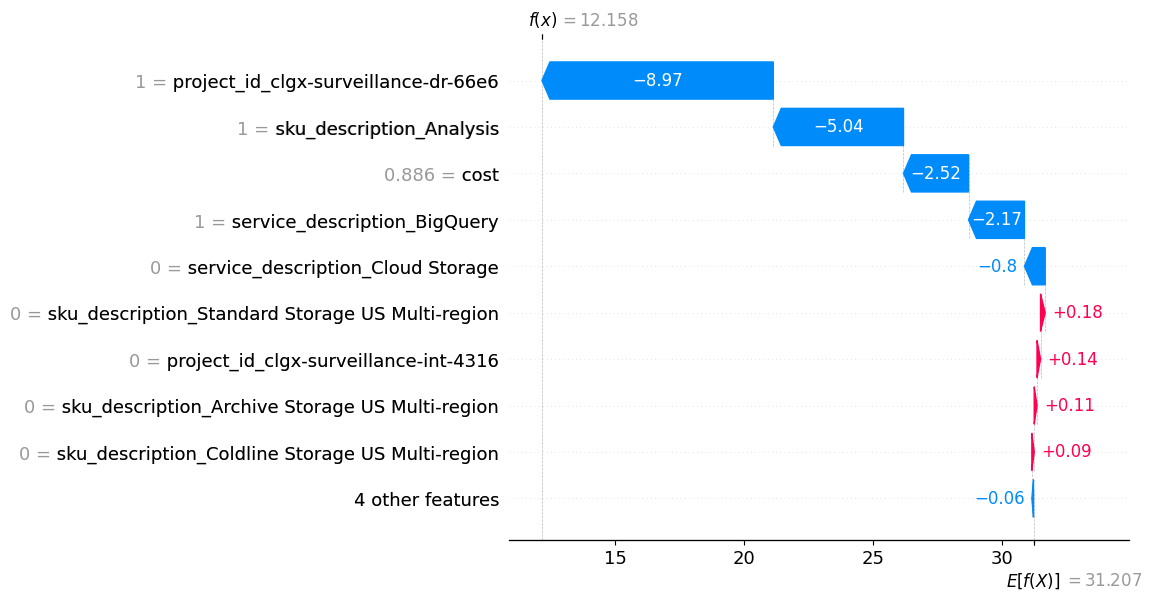

In [41]:
# plot
shap.waterfall_plot(shap_obj[anom_1.index[0]])

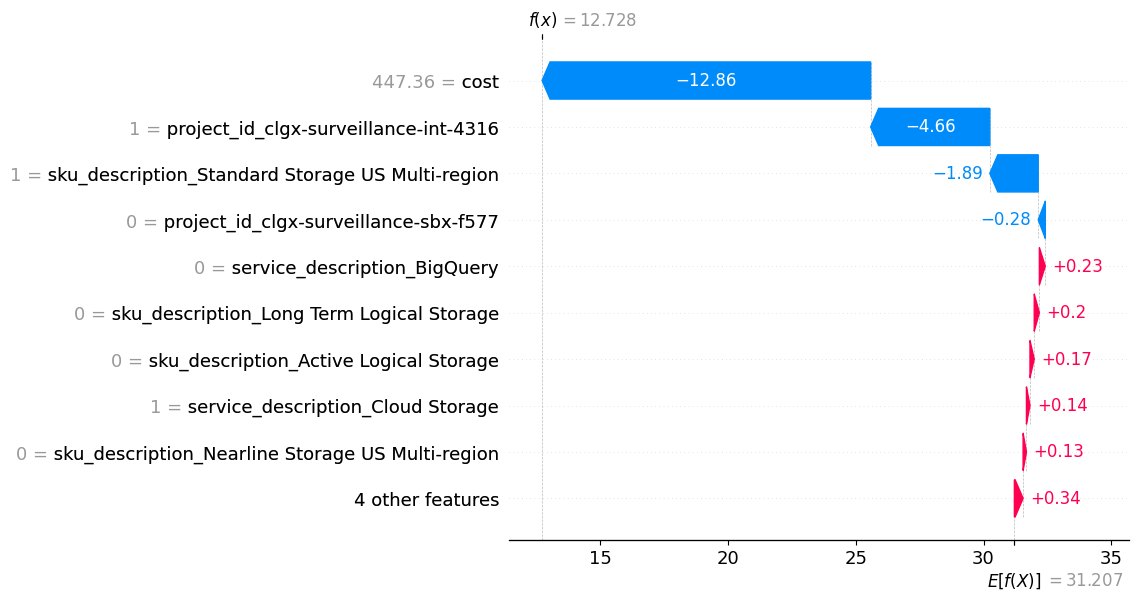

In [42]:
shap.waterfall_plot(shap_obj[14])

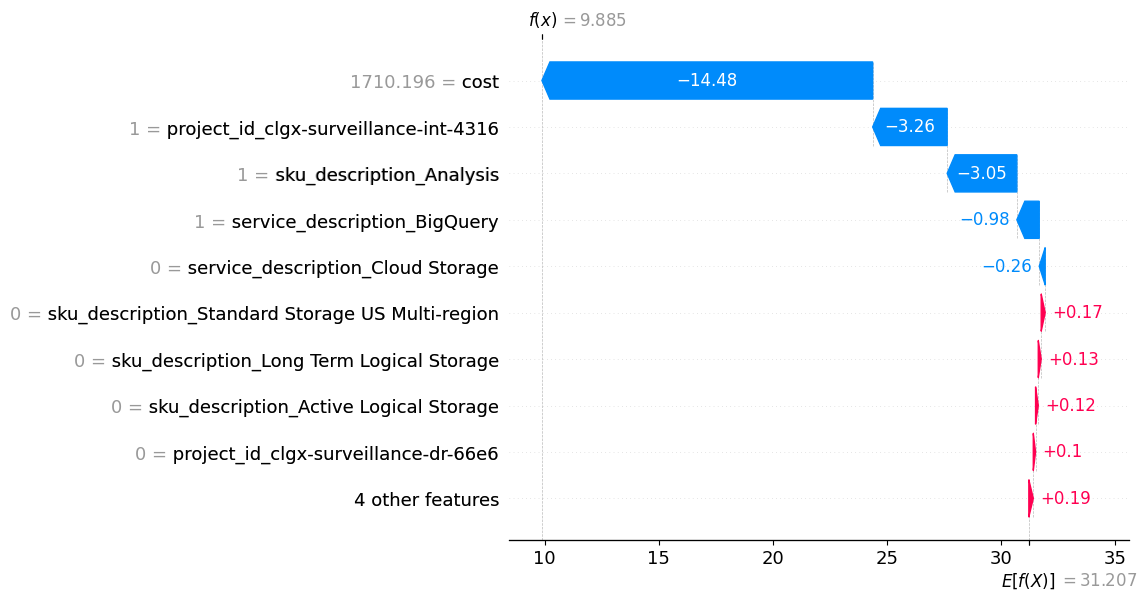

In [43]:
shap.waterfall_plot(shap_obj[12])

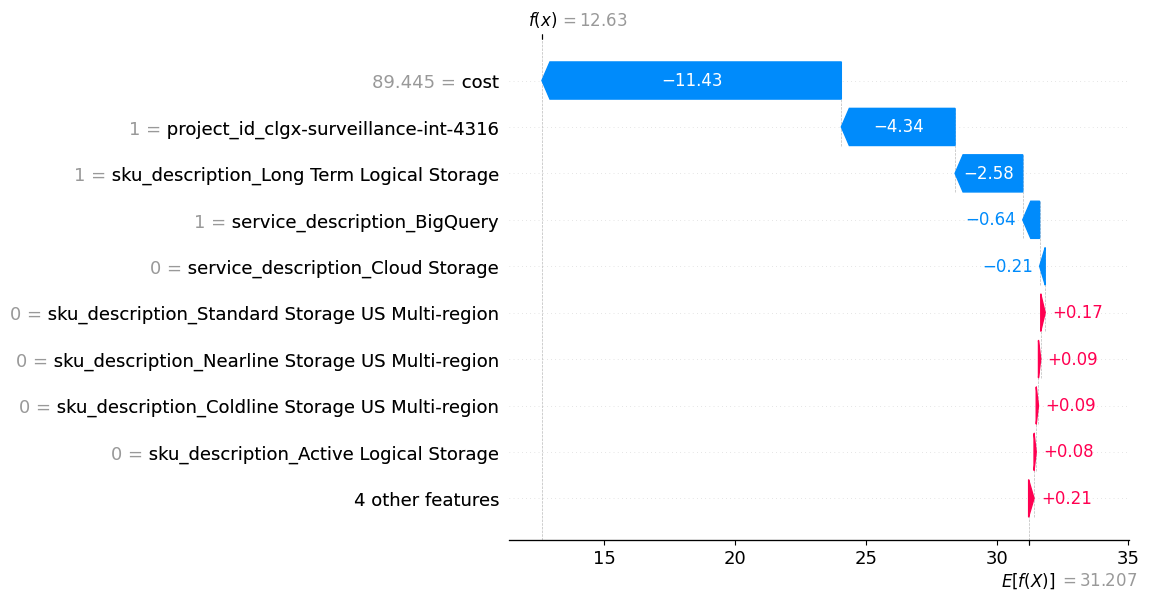

In [47]:
shap.waterfall_plot(shap_obj[18])

In [ ]:
# If confidence >= 68% label = -1
vis_df = df.copy()
vis_df = vis_df.sort_values('invoice_date')
vis_df['prob_score'] = df_res['prob_score']
labels = []
for i in vis_df['prob_score']:
    if i >= 0.68:
        labels.append(-1)
    else:
        labels.append(1)
vis_df['labels'] = labels
vis_df.head()

In [ ]:
anom = vis_df[vis_df['labels'] == -1]
anom['service_description'].value_counts()

In [ ]:
anom

In [ ]:
# Percentage of anomalies
vis_df['labels'].value_counts(normalize = True)

In [ ]:
# Upload to BQ
vis_df.to_gbq('ltaylor.vis_df', 
                 project_id, 
                 chunksize=None, 
                 if_exists='replace')